## Get firing field of selected neuron using behavioral trajectory and processed 2P data from suite2p

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from utils_analysis import plot_trajectory, getTuningMap, getTuningMap_shuffle, getLinearSpeed
from utils_fluorescence import get_deltaF_F_and_fr

### 1, get the trajectory

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
filenamelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
else:
    allX, allZ, allTime, fig = plot_trajectory(datafolder, filenamelist)

#chnage allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#### plot the speed

Text(0, 0.5, 'Speed (m/s)')

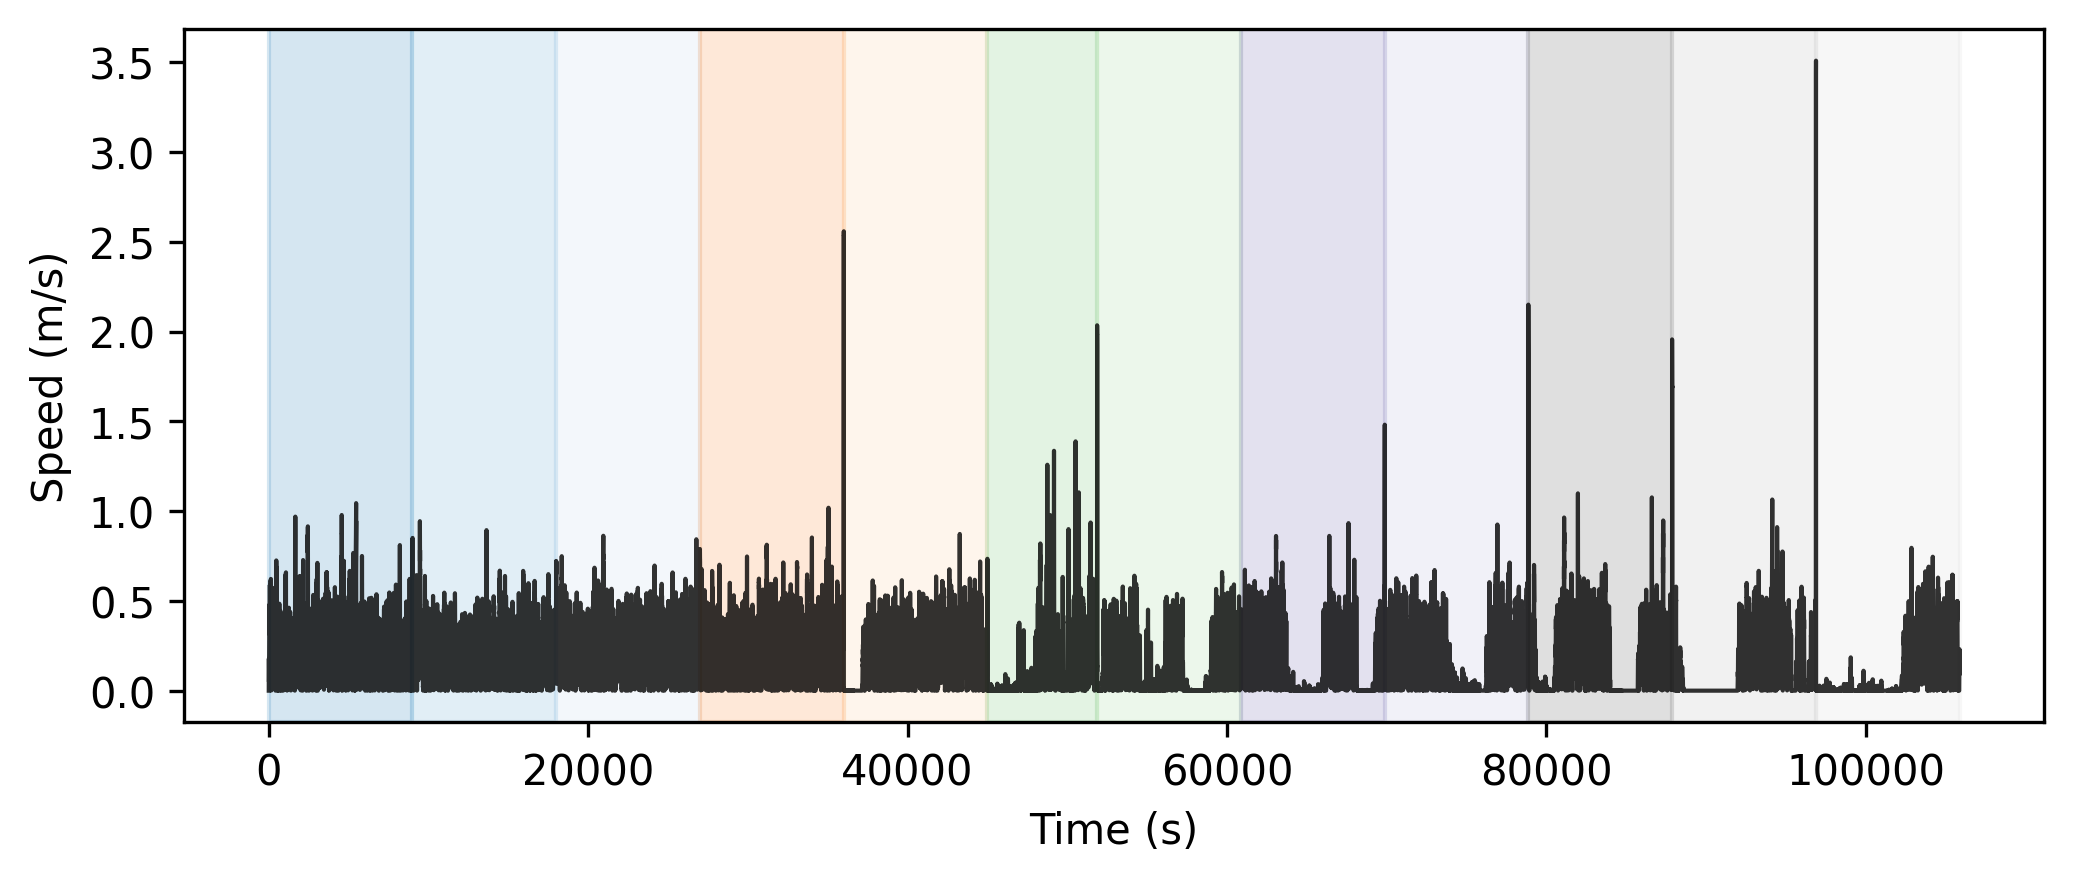

In [3]:
#plot the speed
speed = getLinearSpeed(Traj_x, Traj_z, timestamps, boxcar_size=5)

plt.figure(figsize=(8, 3), dpi=300)

#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))

plt.plot(speed, linewidth=1, color='k', alpha=0.8)

#add horizonatal lines with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i]) for i in range(len(allTime))])
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    #plt.plot([split_ind[i], split_ind[i+1]], [3, 3], color=colors[i], linewidth=2, alpha=1)
    #using shaded region to mark different sessions
    plt.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#xlabel and ylabel  
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

### 2, get suite2p outputs

In [4]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
#load raw fluorescence signal F and neuropil signal Fneu
F = np.load(os.path.join(processed_datafolder, 'F.npy'), allow_pickle=True)
Fneu = np.load(os.path.join(processed_datafolder, 'Fneu.npy'), allow_pickle=True)
#get the neuropil corrected signal Fcorr = F-0.7*Fneu
Fcorr = F - 0.7*Fneu

stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)


#get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
    deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
    fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
else:
    deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
    #save deltaF and fr to processed_datafolder as npy file
    np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
    np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)

### plot one firing rate map

Text(0.5, 1.0, 'Peak=1.34')

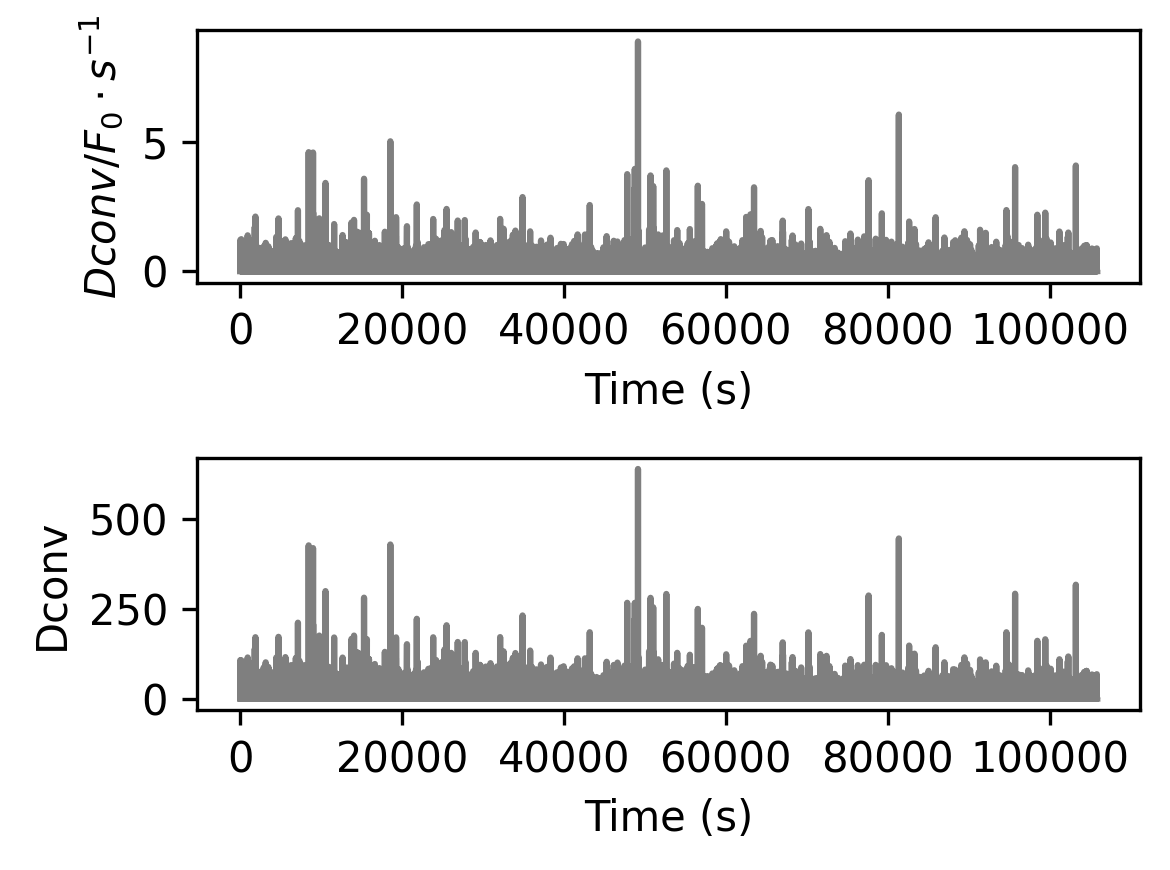

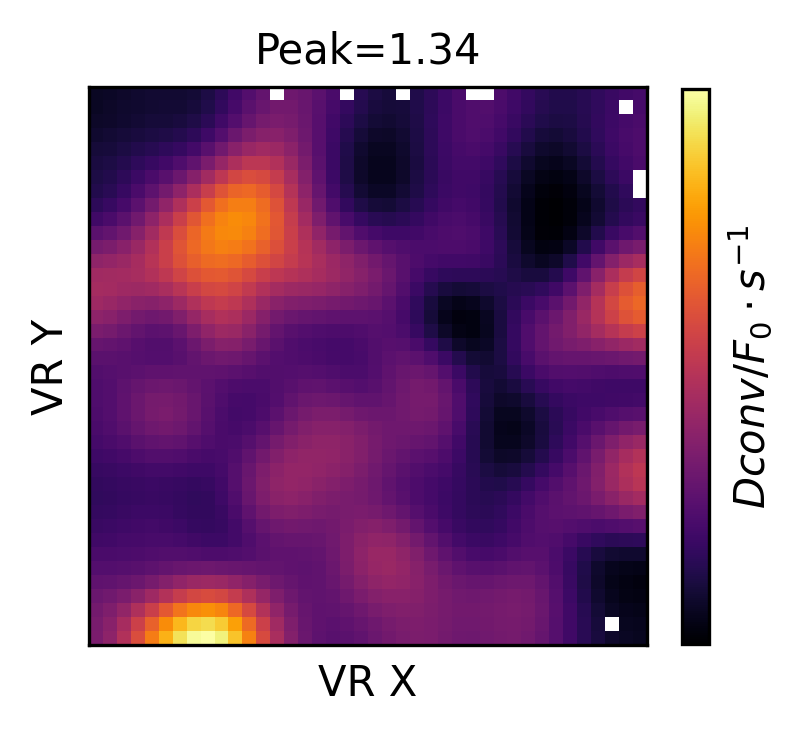

In [5]:
ind=19

fig = plt.figure(figsize=(4, 3), dpi=300)
labelsize = 10
ticksize = 8
plt.subplot(2,1,1)
plt.plot(fr[ind], color='k', alpha=0.5)
plt.xlabel('Time (s)', fontsize=labelsize)
plt.ylabel('$Dconv/F_0 \cdot s^{-1}$', fontsize=labelsize)
plt.subplot(2,1,2)
plt.plot(spks[ind], color='k', alpha=0.5)
plt.xlabel('Time (s)', fontsize=labelsize)
plt.ylabel('Dconv', fontsize=labelsize)
plt.tight_layout()

############################################################################################################

map = getTuningMap(fr[ind], Traj_x, Traj_z, timestamps, VRsize=(1,1), 
                   binsize=(0.025,0.025), sigma=5/2.5, speed_thres=0.025, 
                   boxcar_size=5, visit_thres=0.1,
                   cell_id=ind, datafolder=datafolder)
plt.figure(figsize=(3, 3), dpi=300)
labelsize = 10
ticksize = 8
#imshow the map
plt.imshow(map, cmap='inferno')
#axis off
#plt.axis('off')
#xlabel and ylabel
plt.xlabel('VR X', fontsize=labelsize)
plt.ylabel('VR Y', fontsize=labelsize)
# #set xticks and yticks from 0 to map.shape[0], but relabel them as 0 to 1
# plt.xticks(np.linspace(0, map.shape[0], 5), np.linspace(0, 1, 5), fontsize=ticksize)
# plt.yticks(np.linspace(0, map.shape[1], 5), np.linspace(0, 1, 5), fontsize=ticksize)
plt.xticks([]); plt.yticks([])
#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = plt.colorbar(label='$Dconv/F_0 \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=labelsize)
#add peak value as text at the right top corner of the map, do not overlap with the map
#plt.text(0.5, 1.05, 'Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize, transform=plt.gca().transAxes)
plt.title('Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize)


### 3, getting all firing fields of all neurons with deconv/F0 > 0.8 and spatial information content (SIC) exceeding 95 percentile of the shuffled version

In [38]:
#get the index
cell_idx = np.where(iscell[:,0]==1)[0]
peak_thres = 0.8
peak_up_thres = 100
N=200 #shuffle 200 times

#for each neuron, calculate the tuning map
potentialPC_maps = {}
peaks = []
SIC_real_all = {}
SIC_shuffle_all = {}

for i, key in enumerate(cell_idx):
    print('Getting tuning map of cell '+str(key))
    
    map = getTuningMap(fr[key], Traj_x, Traj_z, timestamps, 
                       VRsize=(1,1), binsize=(0.025,0.025), sigma=3, 
                       speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                       peak_thres=peak_thres, cell_id=key, datafolder=datafolder)
    
    peaks.append(np.nanmax(map))
    
    #filter out the maps with peak value less than peak_thres
    if np.nanmax(map)<peak_thres or np.nanmax(map)>peak_up_thres:
        continue
    
    ############################################################################################################
    #then filter the maps with SIC exceeding 95 percentile of the shuffled map
    #calculate spatial information content of each map in valid_maps
    #spatial information content is calculated as 
    #       sum_i(p_i*\lambda_i/\lambda)log_2(\lambda_i/\lambda)
    #where \lambda_i is the calcium activity in the i-th bin, which is ave_calcium_in_bin_devided_by_counts
    #      \lambda is the mean calcium activity across all bins, which is all_calcium_mean
    #      p_i is the probablity of the mouse visiting the i-th bin, which is prob_visit

    print('Calculating spatial information content of cell '+str(key))
    results = getTuningMap(fr[key], Traj_x, Traj_z, timestamps, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None, return_all=True,
                        apply_adaptive_binning=True)
    
    _, ave_calcium_in_bin_raw, all_calcium_mean, prob_visit, _, _, _ = results
    #calculate the spatial information content
    SICMat_real = prob_visit*ave_calcium_in_bin_raw/all_calcium_mean*np.log2(ave_calcium_in_bin_raw/all_calcium_mean+1e-10)
    SIC_real = np.nansum(SICMat_real)

    #shuffle fr[key] by rolling it with a random number between 0 and 1000
    #and calculate the spatial information content of the shuffled data
    #do this N times
    fr_shuffle = np.zeros((N, len(fr[key])))
    for j in range(N):
        fr_shuffle[j] = np.roll(fr[key], np.random.randint(1800, len(fr[key])-1800))
        
    results = getTuningMap_shuffle(fr_shuffle, Traj_x, Traj_z, timestamps, VRsize=(1,1),
                    binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                    apply_adaptive_binning=True)
    ave_calcium_in_bin_shuffle, all_calcium_mean_shuffle, prob_visit_shuffle, _, _, _ = results
    #calculate the spatial information content for shuffled data
    
    SICMat_shuffle = np.zeros((N, len(prob_visit), len(prob_visit))) 
    for j in range(N):
        SICMat_shuffle[j] = prob_visit_shuffle[j,:,:]*ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]*np.log2(ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]+1e-10)

    SIC_shuffle = np.nansum(SICMat_shuffle, axis=(1,2))

    #for each elemnt in SI_real_all, if it exist 95% percentile in SI_shuffle_all, then select the correpsonding neuron in valid_maps
    #save them to potentialPC_maps with the key as the neuron index and value as the map
    if SIC_real > np.percentile(SIC_shuffle, 95):
        potentialPC_maps[key] = map
        SIC_real_all[key] = SIC_real
        SIC_shuffle_all[key] = SIC_shuffle

#save SIC_real_all, SIC_shuffle_all, and potentialPC_maps into one pickle file in savefolder
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
Potential_PC_results = {'SIC_real_all':SIC_real_all, 'SIC_shuffle_all':SIC_shuffle_all, 'potentialPC_maps':potentialPC_maps}
with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'wb') as f:
    pickle.dump(Potential_PC_results, f)

Getting tuning map of cell 0
Calculating spatial information content of cell 0
Getting tuning map of cell 1
Calculating spatial information content of cell 1
Getting tuning map of cell 2
Calculating spatial information content of cell 2
Getting tuning map of cell 3
Calculating spatial information content of cell 3
Getting tuning map of cell 4
Calculating spatial information content of cell 4
Getting tuning map of cell 5
Calculating spatial information content of cell 5
Getting tuning map of cell 6
Calculating spatial information content of cell 6
Getting tuning map of cell 7
Calculating spatial information content of cell 7
Getting tuning map of cell 8
Calculating spatial information content of cell 8
Getting tuning map of cell 9
Calculating spatial information content of cell 9
Getting tuning map of cell 10
Calculating spatial information content of cell 10
Getting tuning map of cell 11
Calculating spatial information content of cell 11
Getting tuning map of cell 12
Calculating spatia

#### load results from pickle file

In [7]:
#load Potential_PC_results.pickle from the savefolder
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results = pickle.load(f)
SIC_real_all = Potential_PC_results['SIC_real_all']
SIC_shuffle_all = Potential_PC_results['SIC_shuffle_all']
potentialPC_maps = Potential_PC_results['potentialPC_maps']

### 4, plot all firing fields of potential place cells from potentialPC_maps in one figure

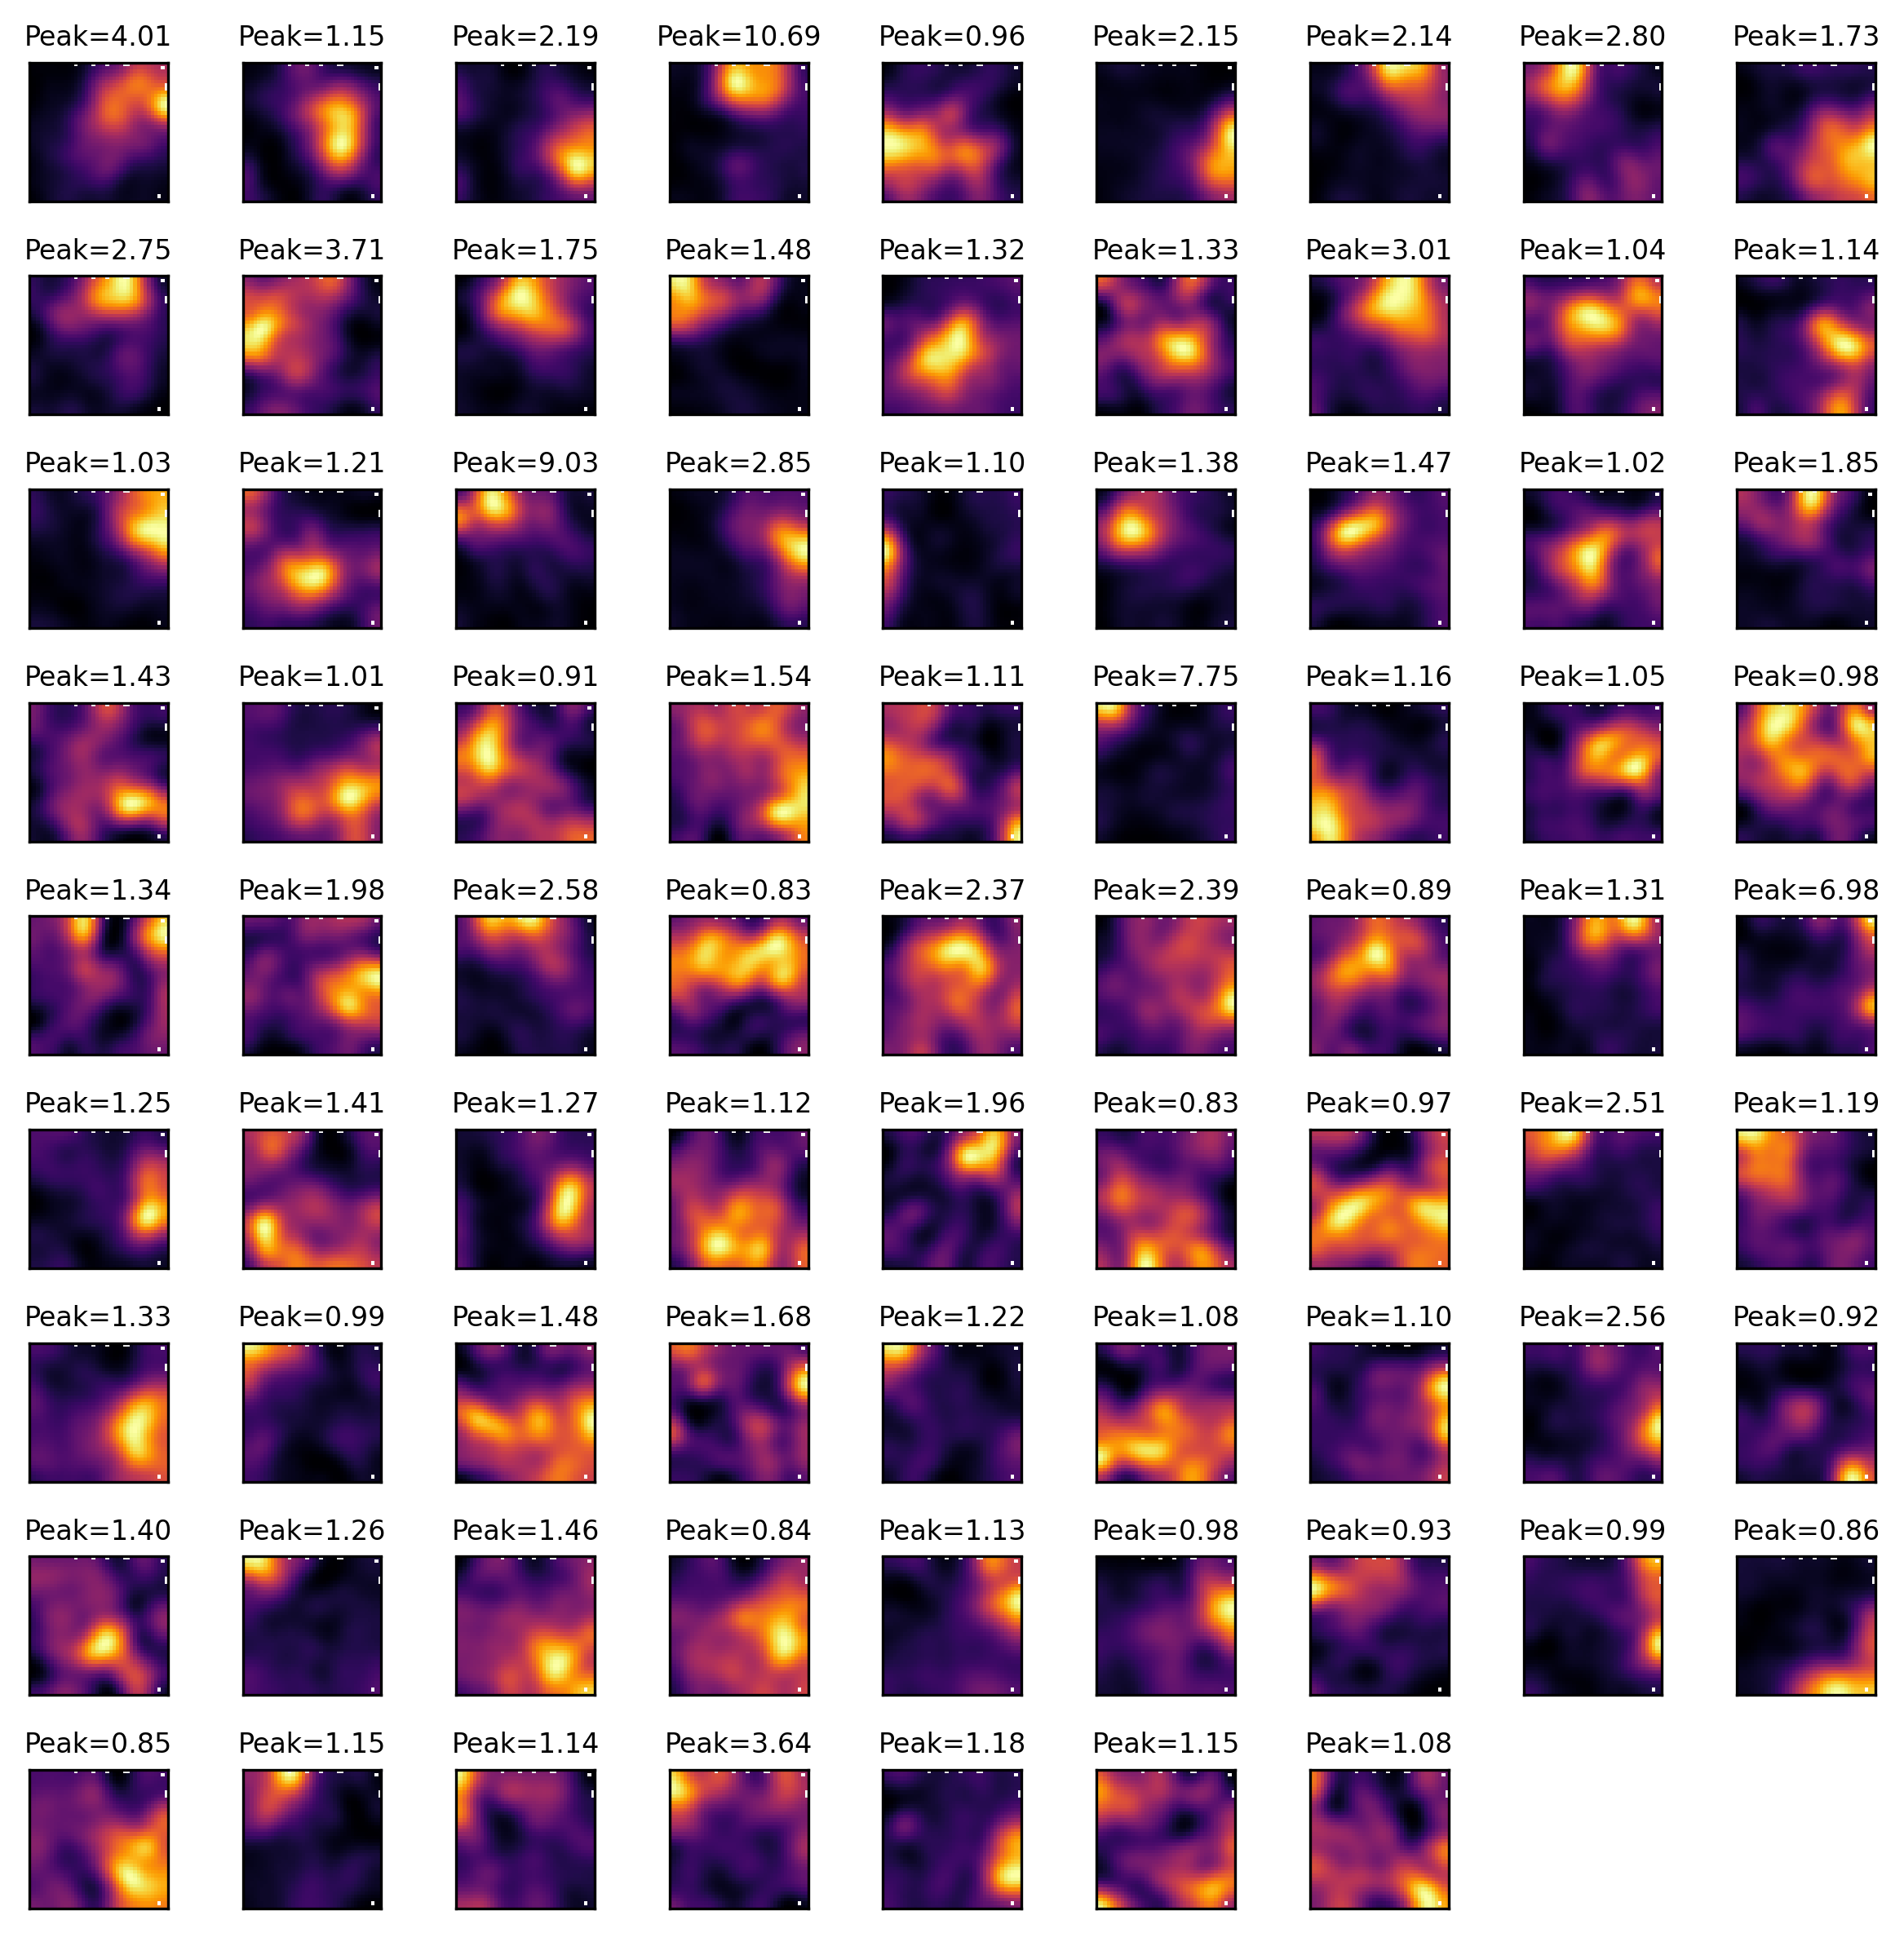

In [8]:
# #plot all selected_valid_maps in subplots
# vmin = np.min([np.nanmin(v) for v in potentialPC_maps.values()])
# vmax = np.max([np.nanmax(v) for v in potentialPC_maps.values()])

# #normalize each map with vmin and vmax
# for k, v in potentialPC_maps.items():
#     potentialPC_maps[k] = (v-vmin)/(vmax-vmin)

#plot all valid maps in subplots
num = len(potentialPC_maps)
#calculate the number of rows and columns, make cols 2 times of rows
rows = int(np.ceil(np.sqrt(num)))
cols = int(np.ceil(np.sqrt(num)))

#
labelsize = 10
ticksize = 8

#set the figure size
plt.figure(figsize=(8,8), dpi=300)

for i, (k, v) in enumerate(potentialPC_maps.items()):
    plt.subplot(rows, cols, i+1)
    plt.imshow(v, cmap='inferno')
    #ticks off
    plt.xticks([]); plt.yticks([])
    #add peak value as title of each subplot, and move it down a little bit
    peak = np.nanmax(v)
    plt.title('Peak={:.2f}'.format(peak), fontsize=ticksize, pad=5)

# #add a shared colorbar
# plt.subplots_adjust(right=0.8)
# #find the bottom of ylim of subplots and align the colorbar with it
# bottom = plt.gca().get_position().get_points()[0][1]
# cax = plt.axes([0.85, bottom, 0.03, 0.5])
# #add colorbar with label size = 10 and tick size = 8
# plt.colorbar(cax=cax, label='Decovolved calcium activity (normalized)')
# cax.tick_params(labelsize=ticksize)

plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'potentialPC_tuningmaps_all.pdf'), dpi=300, bbox_inches='tight')

### 5, for selected neurons, plot the firing field in the first half and second half recording

Getting half tuning maps of cell 0


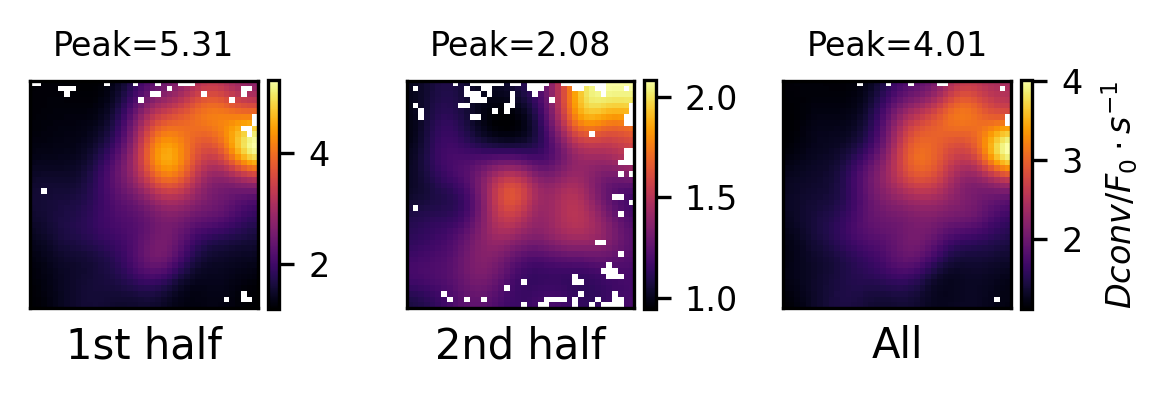

Getting half tuning maps of cell 1
Getting half tuning maps of cell 2
Getting half tuning maps of cell 3
Getting half tuning maps of cell 4
Getting half tuning maps of cell 5
Getting half tuning maps of cell 6
Getting half tuning maps of cell 7
Getting half tuning maps of cell 8
Getting half tuning maps of cell 9
Getting half tuning maps of cell 10
Getting half tuning maps of cell 11
Getting half tuning maps of cell 12
Getting half tuning maps of cell 13
Getting half tuning maps of cell 14
Getting half tuning maps of cell 15
Getting half tuning maps of cell 16
Getting half tuning maps of cell 17
Getting half tuning maps of cell 20
Getting half tuning maps of cell 22
Getting half tuning maps of cell 23
Getting half tuning maps of cell 24
Getting half tuning maps of cell 28
Getting half tuning maps of cell 31
Getting half tuning maps of cell 35
Getting half tuning maps of cell 36
Getting half tuning maps of cell 37
Getting half tuning maps of cell 43
Getting half tuning maps of cell 54
G

In [26]:
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P', 'tuningmaps_halfcompare')
#if not exist, create the folder
#if exist, remove it and create a new one
if not os.path.exists(savefolder):
    os.makedirs(savefolder)
    
labelsize = 10
ticksize = 8

#for each neuron, calculate the tuning map
for indx, key in enumerate(potentialPC_maps.keys()):
    print('Getting half tuning maps of cell '+str(key))
    #first one plot the first half data
    fig, axs = plt.subplots(1, 3, figsize=(4, 1.5), dpi=300)
    
    half1_fr_cells = fr[key][timestamps<timestamps[len(timestamps)//2]]
    half1_Traj_x = Traj_x[timestamps<timestamps[len(timestamps)//2]]
    half1_Traj_z = Traj_z[timestamps<timestamps[len(timestamps)//2]]
    half1_timestamps = timestamps[timestamps<timestamps[len(timestamps)//2]]
    
    map1 = getTuningMap(half1_fr_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    img0 = axs[0].imshow(map1, cmap='inferno')
    axs[0].set_xlabel('1st half', fontsize=labelsize)
    #ticks off
    axs[0].set_xticks([]); axs[0].set_yticks([])
    #add colorbar with the same height as the image
    cbar1 = plt.colorbar(img0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.ax.tick_params(labelsize=ticksize)
    #add title of peak value
    axs[0].set_title('Peak={:.2f}'.format(np.nanmax(map1)), fontsize=ticksize)
    
    #second one plot the second half data
    half2_fr_cells = fr[key][timestamps>=timestamps[len(timestamps)//2]]
    half2_Traj_x = Traj_x[timestamps>=timestamps[len(timestamps)//2]]
    half2_Traj_z = Traj_z[timestamps>=timestamps[len(timestamps)//2]]
    half2_timestamps = timestamps[timestamps>=timestamps[len(timestamps)//2]]
    map2 = getTuningMap(half2_fr_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    img1 = axs[1].imshow(map2, cmap='inferno')
    axs[1].set_xlabel('2nd half', fontsize=labelsize)
    #ticks off
    axs[1].set_xticks([]); axs[1].set_yticks([])
    #add colorbar
    cbar2 = plt.colorbar(img1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar2.ax.tick_params(labelsize=ticksize)
    #set tile of peak value
    axs[1].set_title('Peak={:.2f}'.format(np.nanmax(map2)), fontsize=ticksize)
    
    #third one plot the whole data
    map3 = getTuningMap(fr[key], Traj_x, Traj_z, timestamps, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting

    img2 = axs[2].imshow(map3, cmap='inferno')
    axs[2].set_xlabel('All', fontsize=labelsize)
    #ticks off
    axs[2].set_xticks([]); axs[2].set_yticks([])
    #add colorbar
    cbar3 = plt.colorbar(img2, ax=axs[2], fraction=0.046, pad=0.04)
    cbar3.ax.tick_params(labelsize=ticksize)
    #add colobar label
    cbar3.set_label('$Dconv/F_0 \cdot s^{-1}$', fontsize=ticksize)
    #add title of peak value
    axs[2].set_title('Peak={:.2f}'.format(np.nanmax(map3)), fontsize=ticksize)
    
    plt.tight_layout()
    
    #save the map
    plt.savefig(os.path.join(savefolder, 'firingmap_'+str(key)+'.pdf'), dpi=300)
    #show the first figure here and close the others
    if indx == 0:
        plt.show()
    else:
        plt.close()


### 6, plot several deconvolved calcium traces of selected neurons

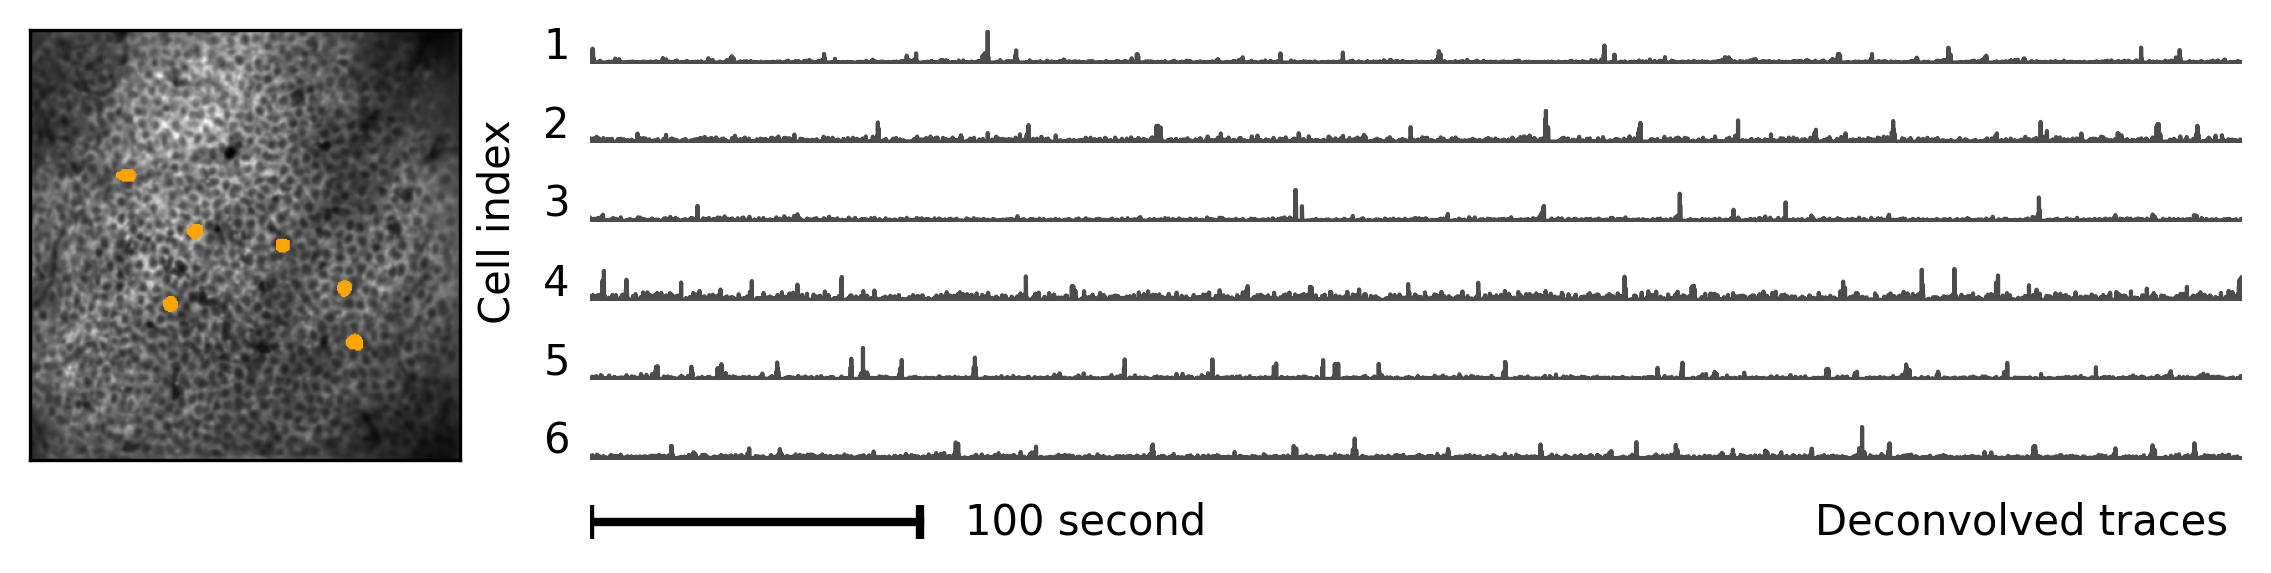

In [9]:
#select the first N neurons
N = 6
keys = list(potentialPC_maps.keys())[:N]
frame_length = 15000

#plot the traces of these 10 neurons
#each in a subplot
fig = plt.figure(figsize=(8, 2), dpi=300)
labelsize = 10
ticksize = 8

gs = GridSpec(N+1, 2, width_ratios=[1,3]) 

#on the left show the mean image 
ax = fig.add_subplot(gs[:N, 0])
meanImage = ops['meanImg']
#transfer to RGB image
meanImage = np.stack((meanImage,)*3, axis=-1)
#normalize to [0,255] and change to uint8
meanImage = (meanImage-np.min(meanImage))/(np.max(meanImage)-np.min(meanImage))*255
meanImage = meanImage.astype(np.uint8)
#ticks off
ax.set_xticks([]); ax.set_yticks([])
#for each of the N neurons, mark the pixels as red  
for i, k in enumerate(keys):
    #get the x and y coordinates of the neuron
    x = stats[k]['xpix']
    y = stats[k]['ypix']
    #mark the pixels as orange, but 50% transparent
    meanImage[x, y, :] =  [255, 165, 0]

ax.imshow(meanImage)

for i, k in enumerate(keys):
    ax = fig.add_subplot(gs[i, 1:])
    ax.plot(np.arange(frame_length), spks[k][:frame_length], color='k', linewidth=1, alpha=0.7)
    ax.set_xticks([]); ax.set_yticks([])
    #box invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ylabel and move it down a bit to align with the bottom edge of the subplot
    #plt.ylabel(str(k+1), fontsize=labelsize, rotation=0, labelpad=10)
    ax.set_ylabel(str(k+1), fontsize=labelsize, rotation=0, labelpad=10)
    #adjust the ylabel to move it down
    #plt.gca().yaxis.set_label_coords(-0.02, -0.1)
    ax.yaxis.set_label_coords(-0.02, -0.1)
    #xlim
    #plt.xlim([0, frame_length])
    ax.set_xlim([0, frame_length])
    

#add a horizontal line to mark the time length of 100 seconds, whcih equals to 3000 frames  
#show with equal 
ax = fig.add_subplot(gs[N, 1:])
ax.plot([0, 30*100], [0, 0], color='k', linewidth=2, alpha=1)
#add two short veritcal lines to mark the beginning and end of the 100 seconds
ax.plot([0, 0], [-0.05, 0.05], color='k', linewidth=2, alpha=1)
ax.plot([30*100, 30*100], [-0.05, 0.05], color='k', linewidth=2, alpha=1)
#box invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#xy ticks off
ax.set_xticks([]); ax.set_yticks([])
#xlim
ax.set_xlim([0, frame_length])
#add text below the line
ax.text(4500, -0.04, '100 second', fontsize=labelsize, horizontalalignment='center')
ax.text(frame_length-2000, -0.04, 'Deconvolved traces', fontsize=labelsize, horizontalalignment='center')

#add a sup title on the left side of all plots
# plt.suptitle('Cell index', fontsize=labelsize,  rotation='vertical', x=0.0, y=0.52)
fig.text(0.23, 0.45, 'Cell index', fontsize=labelsize,  rotation='vertical')

plt.tight_layout()

savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'deconvolved_traces.pdf'), dpi=300, bbox_inches='tight')



### 7, get the spatial information content of one select neuron and all neurons

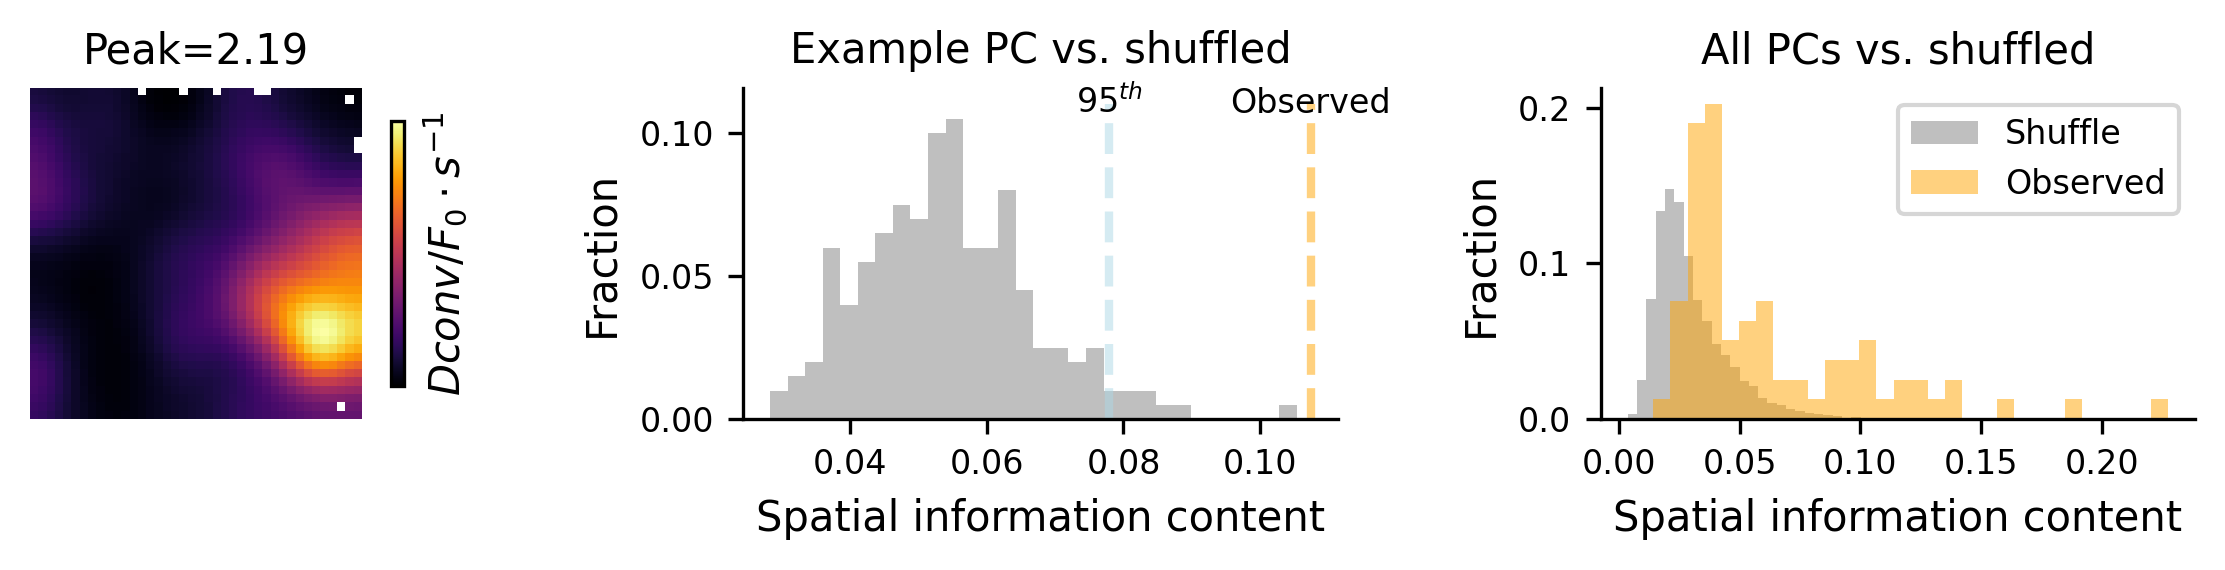

In [10]:
#plot  histogram, but with different colors
fig, axs = plt.subplots(1, 3, figsize=(8, 2), dpi=300)
labelsize = 10
ticksize = 8
key = 2
numbins = 30

#plot the example tuning map
map = potentialPC_maps[key]

#imshow the map
axs[0].imshow(map, cmap='inferno')
#axis off ticks off
axs[0].axis('off')
axs[0].set_xticks([]); axs[0].set_yticks([])

#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = axs[0].figure.colorbar(axs[0].images[0], ax=axs[0], label='$Dconv/F_0 \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=ticksize)
#add peak as title
axs[0].set_title('Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize)

#plot the histgram of SIC of the selected neuron, normalized histogram
SIC_shuffle_selected = SIC_shuffle_all[key]
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(SIC_shuffle_selected, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
axs[1].bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')
#add 95 percentile of the SIC_shuffle_selected as a vertical line
percentile_95 = np.percentile(SIC_shuffle_selected, 95)
yuplim = axs[1].get_ylim()[1]
axs[1].plot([percentile_95, percentile_95], [0, yuplim], color='lightblue', linewidth=2, alpha=0.5, linestyle='--')
#add text to label the percentile marked as 95^{th}
axs[1].text(percentile_95, 0.95*yuplim, '95$^{th}$', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom')
#add the real SIC as a orange vertical line, dashed
SIC_real_selected = SIC_real_all[key]
axs[1].plot([SIC_real_selected, SIC_real_selected], [0, yuplim], color='orange', linewidth=2, alpha=0.5, linestyle='--')
#add text to label the real SIC
axs[1].text(SIC_real_selected, 0.95*yuplim, 'Observed', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom')
#right and top axis off
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
#x y labels
axs[1].set_xlabel('Spatial information content', fontsize=labelsize)
axs[1].set_ylabel('Fraction', fontsize=labelsize)
axs[1].set_title('Example PC vs. shuffled', fontsize=labelsize)
axs[1].tick_params(labelsize=ticksize)

#plot the histogram of SIC of all neurons
shuffle_all = np.concatenate(list(SIC_shuffle_all.values()))
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(shuffle_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
axs[2].bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')

real_all = np.array(list(SIC_real_all.values()))
#count the number of elements in each bin  using np.histogram for SIC_real_all
counts, bins = np.histogram(real_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the bar with facecolor edgecolor as orange
axs[2].bar(bins[:-1], counts, width=bins[1]-bins[0], color='orange', alpha=0.5, label='Observed')
#histtype='step', 

axs[2].legend(fontsize=ticksize)
#axs[0].set_xlabel('Spatial information content', fontsize=labelsize)
axs[2].set_ylabel('Fraction', fontsize=labelsize)
axs[2].tick_params(labelsize=ticksize)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
#title
axs[2].set_title('All PCs vs. shuffled', fontsize=labelsize)

#x y labels
axs[2].set_xlabel('Spatial information content', fontsize=labelsize)
axs[2].set_ylabel('Fraction', fontsize=labelsize)

plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'Spatial_information_content.pdf'), dpi=300, bbox_inches='tight')

### 8, get the spatial information content of one select neuron and all neurons in first half and second half recording

In [16]:
#for each neuron, calculate the tuning map
Corr_real_all = {}
Corr_shuffle_all = {}
potentialPC_maps_halfs = {}
half_time = timestamps[len(timestamps)//2]

for i, key in enumerate(potentialPC_maps.keys()):
    print('Calculating spatial information content of cell '+str(key))
    
    half1_fr_cells = fr[key][timestamps<half_time]
    half1_Traj_x = Traj_x[timestamps<half_time]
    half1_Traj_z = Traj_z[timestamps<half_time]
    half1_timestamps = timestamps[timestamps<half_time]
    
    map1_real = getTuningMap(half1_fr_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None,
                        apply_adaptive_binning = True) #set peak_thres to a large number to avoid plotting
    
    #second one plot the second half data
    half2_fr_cells = fr[key][timestamps>=half_time]
    half2_Traj_x = Traj_x[timestamps>=half_time]
    half2_Traj_z = Traj_z[timestamps>=half_time]
    half2_timestamps = timestamps[timestamps>=half_time]
    map2_real = getTuningMap(half2_fr_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None,
                        apply_adaptive_binning = True) #set peak_thres to a large number to avoid plotting
    
    #add both maps to potentialPC_maps_halfs
    potentialPC_maps_halfs[key] = [map1_real, map2_real]
    
    
    #set nan values as o in both maps
    map1_real[np.isnan(map1_real)] = 0
    map2_real[np.isnan(map2_real)] = 0
    
    #calculate the correlation coefficient
    corr_real =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all[key] = corr_real
    
    #shuffle fr[i] by rolling it with a random number between 0 and 1800
    #do this N times
    N=200
    corr_shuffle = np.zeros(N)
    fr_shuffle = np.zeros((N, len(fr[key])))
    for j in range(N):
        fr_shuffle[j] = np.roll(fr[key], np.random.randint(1800, 100000))
    
    half1_fr_cells = fr_shuffle[:,timestamps<half_time] 
    #return map using getTuningMap_shuffle
    map1_shuffle_all = getTuningMap_shuffle(half1_fr_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                                binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                                return_gaussian_filtered=True, apply_adaptive_binning = True)
    
    half2_fr_cells = fr_shuffle[:,timestamps>=half_time]
    map2_shuffle_all = getTuningMap_shuffle(half2_fr_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                                binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                                return_gaussian_filtered=True, apply_adaptive_binning = True)
    
    #for each shuffled data, calculate the correlation coefficient
    for j in range(N):
        #set nan values as o in both maps
        map1_shuffle = map1_shuffle_all[j]
        map2_shuffle = map2_shuffle_all[j]
        map1_shuffle[np.isnan(map1_shuffle)] = 0
        map2_shuffle[np.isnan(map2_shuffle)] = 0
        #calculate the correlation coefficient
        corr_shuffle[j] =  np.corrcoef(map1_shuffle.flatten(), map2_shuffle.flatten())[0,1]

            
    Corr_shuffle_all[key] = corr_shuffle
    
#save Corr_real_all, Corr_shuffle_all, and potentialPC_maps_halfs into one pickle file in savefolder
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
Potential_PC_results_halfs = {'Corr_real_all':Corr_real_all, 'Corr_shuffle_all':Corr_shuffle_all, 'potentialPC_maps_halfs':potentialPC_maps_halfs}
with open(os.path.join(savefolder, 'Potential_PC_results_halfs.pickle'), 'wb') as f:
    pickle.dump(Potential_PC_results_halfs, f)


Calculating spatial information content of cell 0


Calculating spatial information content of cell 1
Calculating spatial information content of cell 2
Calculating spatial information content of cell 3
Calculating spatial information content of cell 4
Calculating spatial information content of cell 5
Calculating spatial information content of cell 6
Calculating spatial information content of cell 7
Calculating spatial information content of cell 8
Calculating spatial information content of cell 9
Calculating spatial information content of cell 10
Calculating spatial information content of cell 11
Calculating spatial information content of cell 12
Calculating spatial information content of cell 13
Calculating spatial information content of cell 14
Calculating spatial information content of cell 15
Calculating spatial information content of cell 16
Calculating spatial information content of cell 17
Calculating spatial information content of cell 20
Calculating spatial information content of cell 22
Calculating spatial information content 

In [11]:
#load Potential_PC_results_halfs.pickle from the savefolder
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
with open(os.path.join(savefolder, 'Potential_PC_results_halfs.pickle'), 'rb') as f:
    Potential_PC_results_halfs = pickle.load(f)
Corr_real_all = Potential_PC_results_halfs['Corr_real_all']
Corr_shuffle_all = Potential_PC_results_halfs['Corr_shuffle_all']
potentialPC_maps_halfs = Potential_PC_results_halfs['potentialPC_maps_halfs']

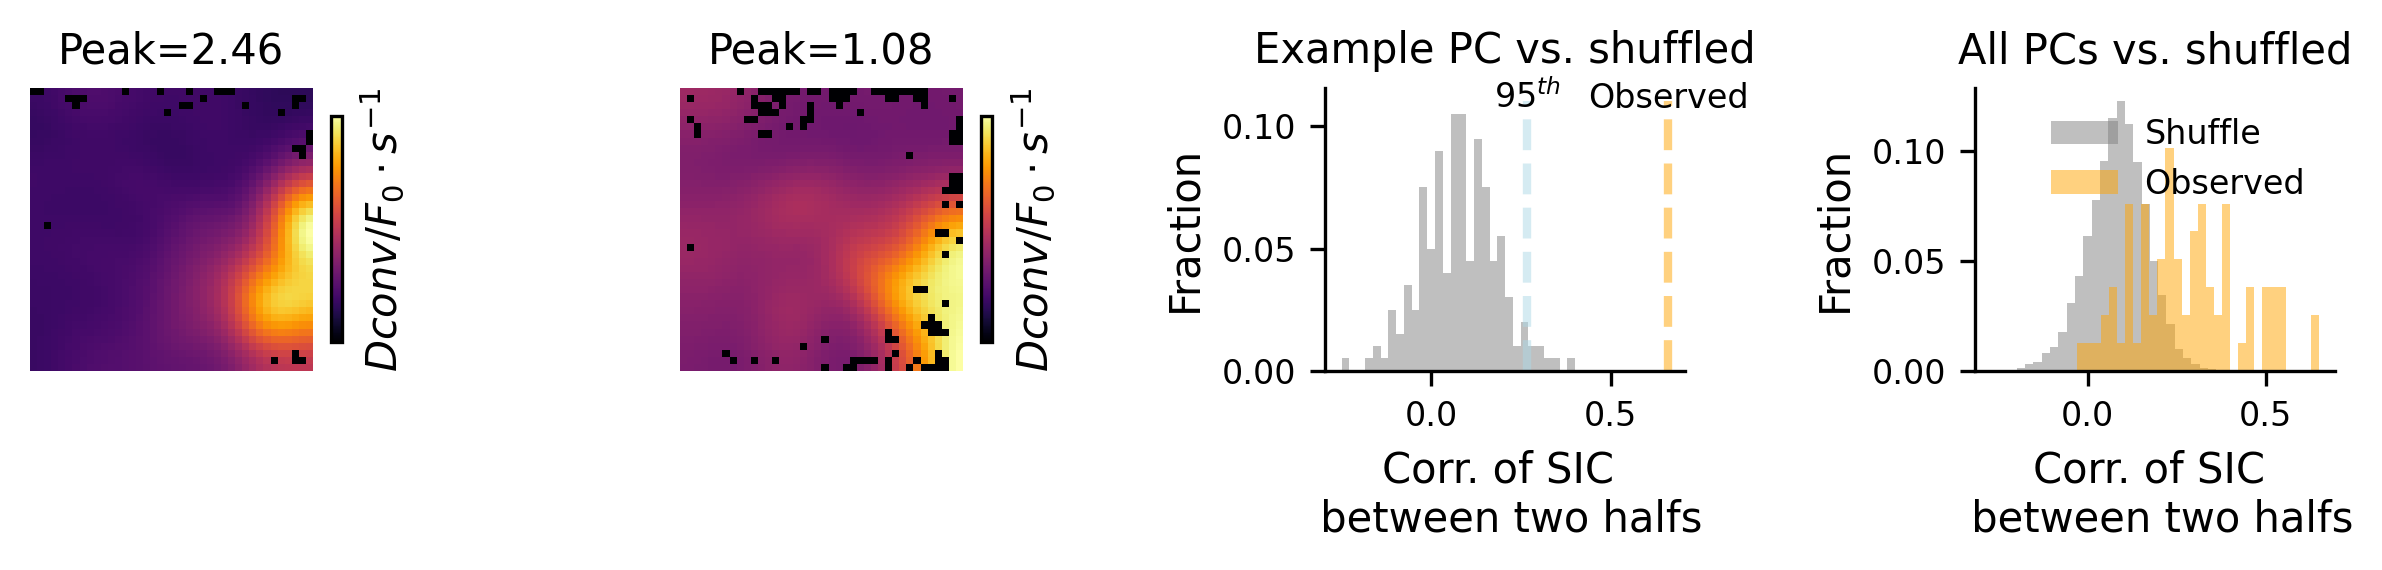

In [45]:
#plot, 4 subplots, width 0.5:0.5:1:1
fig, axs = plt.subplots(1, 4, figsize=(8, 2), dpi=300)
labelsize = 10
ticksize = 8
key = 5
numbins = 30

#plot the example tuning map
map1, map2 = potentialPC_maps_halfs[key]

#imshow the map1
axs[0].imshow(map1, cmap='inferno')
#axis off ticks off
axs[0].axis('off')
axs[0].set_xticks([]); axs[0].set_yticks([])

#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = axs[0].figure.colorbar(axs[0].images[0], ax=axs[0], label='$Dconv/F_0 \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=ticksize)
#add peak as title
axs[0].set_title('Peak={:.2f}'.format(np.nanmax(map1)), fontsize=labelsize)

#imahow the map2
axs[1].imshow(map2, cmap='inferno')
#axis off ticks off
axs[1].axis('off')
axs[1].set_xticks([]); axs[1].set_yticks([])

#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = axs[1].figure.colorbar(axs[1].images[0], ax=axs[1], label='$Dconv/F_0 \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=ticksize)
#add peak as title
axs[1].set_title('Peak={:.2f}'.format(np.nanmax(map2)), fontsize=labelsize)

##############################################################################################################
#plot the histgram of correlation of the selected neuron, normalized histogram
Corr_shuffle_selected = Corr_shuffle_all[key]
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(Corr_shuffle_selected, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
axs[2].bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')
#add 95 percentile of the Corr_shuffle_selected as a vertical line
percentile_95 = np.percentile(Corr_shuffle_selected, 95)
yuplim = axs[2].get_ylim()[1]
axs[2].plot([percentile_95, percentile_95], [0, yuplim], color='lightblue', linewidth=2, alpha=0.5, linestyle='--')
#add text to label the percentile marked as 95^{th}
axs[2].text(percentile_95, 0.95*yuplim, '95$^{th}$', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom')
#add the real SIC as a orange vertical line, dashed
Corr_real_selected = Corr_real_all[key]
axs[2].plot([Corr_real_selected, Corr_real_selected], [0, yuplim], color='orange', linewidth=2, alpha=0.5, linestyle='--')
#add text to label the real SIC
axs[2].text(Corr_real_selected, 0.95*yuplim, 'Observed', fontsize=ticksize, horizontalalignment='center', verticalalignment='bottom')
#right and top axis off
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
#x y labels
axs[2].set_xlabel('Corr. of SIC \n between two halfs', fontsize=labelsize)
axs[2].set_ylabel('Fraction', fontsize=labelsize)
axs[2].set_title('Example PC vs. shuffled', fontsize=labelsize)
axs[2].tick_params(labelsize=ticksize)

##############################################################################################################
#plot the histogram of Correlation of all neurons
shuffle_all = np.concatenate(list(Corr_shuffle_all.values()))
#count the number of elements in each bin  using np.histogram
counts, bins = np.histogram(shuffle_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the histogram
axs[3].bar(bins[:-1], counts, width=bins[1]-bins[0], color='gray', alpha=0.5, label='Shuffle')

real_all = np.array(list(Corr_real_all.values()))
#count the number of elements in each bin  using np.histogram for SIC_real_all
counts, bins = np.histogram(real_all, bins=numbins, density=True)
#normalize the counts in each bin by the total number of counts
counts = counts/np.sum(counts)
#plot the bar with facecolor edgecolor as orange
axs[3].bar(bins[:-1], counts, width=bins[1]-bins[0], color='orange', alpha=0.5, label='Observed')
#histtype='step', 

#legend box off
axs[3].legend(fontsize=ticksize, frameon=False)
#axs[0].set_xlabel('Spatial information content', fontsize=labelsize)
axs[3].set_ylabel('Fraction', fontsize=labelsize)
axs[3].tick_params(labelsize=ticksize)
axs[3].spines['right'].set_visible(False)
axs[3].spines['top'].set_visible(False)
#title
axs[3].set_title('All PCs vs. shuffled', fontsize=labelsize)

#x y labels
axs[3].set_xlabel('Corr. of SIC \n between two halfs', fontsize=labelsize)
axs[3].set_ylabel('Fraction', fontsize=labelsize)

plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'Correlation_half_session.pdf'), dpi=300, bbox_inches='tight')

### 9, compare SIC of all neurons with shuffled version both in the raw env and center crop env

In [12]:
#calculate spatial information content of each map in valid_maps
#spatial information content is calculated as 
#       sum_i(p_i*\lambda_i/\lambda)log_2(\lambda_i/\lambda)
#where \lambda_i is the calcium activity in the i-th bin, which is ave_calcium_in_bin_devided_by_counts
#      \lambda is the mean calcium activity across all bins, which is all_calcium_mean
#      p_i is the probablity of the mouse visiting the i-th bin, which is prob_visit

SIC_real_all = []; SIC_real_all_cut = []
SIC_shuffle_all = []; SIC_shuffle_all_cut = []
for i, key in enumerate(potentialPC_maps.keys()):
    # if i != 1:
    #     continue
    print('Calculating spatial information content of cell '+str(key))
    #spks[key]
    results = getTuningMap(spks[key], Traj_x, Traj_z, timestamps, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None, return_all=True)
    
    _, ave_calcium_in_bin_raw, all_calcium_mean, prob_visit, ave_calcium_in_bin_raw_cut, all_calcium_mean_cut, prob_visit_cut = results
    #calculate the spatial information content
    SICMat_real = prob_visit*ave_calcium_in_bin_raw/all_calcium_mean*np.log2(ave_calcium_in_bin_raw/all_calcium_mean+1e-10)
    SIC_real = np.nansum(SICMat_real)
    #print(SIC_real)
    
    #cut the border for 5 pixels and keep the remaining 30*30 pixels
    SICMat_real_cut =  prob_visit_cut*ave_calcium_in_bin_raw_cut/all_calcium_mean_cut*np.log2(ave_calcium_in_bin_raw_cut/all_calcium_mean_cut+1e-10)
    SIC_real_cut = np.nansum(SICMat_real_cut)
    #SIC_real_cut = np.nansum(SICMat_real[5:-5, 5:-5])
        
    #shuffle spks[key] by rolling it with a random number between 0 and 1000
    #and calculate the spatial information content of the shuffled data
    #do this 100 times
    N=200
    spks_shuffle = np.zeros((N, len(spks[key])))
    for j in range(N):
        spks_shuffle[j] = np.roll(spks[key], np.random.randint(1800, 100000))
        #permute the spks[key] by random
        #spks_shuffle[j] = np.random.permutation(spks[key])
        
    results = getTuningMap_shuffle(spks_shuffle, Traj_x, Traj_z, timestamps, VRsize=(1,1),
                    binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1)
    ave_calcium_in_bin_shuffle, all_calcium_mean_shuffle, prob_visit_shuffle, ave_calcium_in_bin_shuffle_cut, all_calcium_mean_shuffle_cut, prob_visit_shuffle_cut = results
    #calculate the spatial information content for each shuffled data
    #with ave_calcium_in_bin_shuffle [N, 40, 40]
    #all_calcium_mean_shuffle [N]
    
    SICMat_shuffle = np.zeros((N, len(prob_visit), len(prob_visit))) 
    for j in range(N):
        SICMat_shuffle[j] = prob_visit_shuffle[j,:,:]*ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]*np.log2(ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]+1e-10)

    #cut the border for 5 pixels and keep the remaining 30*30 pixels
    SICMat_shuffle_cut = np.zeros((N, len(prob_visit_cut), len(prob_visit_cut)))
    for j in range(N):
        SICMat_shuffle_cut[j] = prob_visit_shuffle_cut[j,:,:]*ave_calcium_in_bin_shuffle_cut[j,:,:]/all_calcium_mean_shuffle_cut[j]*np.log2(ave_calcium_in_bin_shuffle_cut[j,:,:]/all_calcium_mean_shuffle_cut[j]+1e-10)
    
    SIC_shuffle = np.nansum(SICMat_shuffle, axis=(1,2))
    SIC_shuffle_cut = np.nansum(SICMat_shuffle_cut, axis=(1,2))
    #SIC_shuffle_cut = np.nansum(SICMat_shuffle[:,5:-5,5:-5], axis=(1,2))
    #print(SIC_shuffle)
    
    SIC_real_all.append(SIC_real)
    SIC_shuffle_all.append(SIC_shuffle)
    SIC_real_all_cut.append(SIC_real_cut)
    SIC_shuffle_all_cut.append(SIC_shuffle_cut)


Calculating spatial information content of cell 0
Calculating spatial information content of cell 1
Calculating spatial information content of cell 2
Calculating spatial information content of cell 3
Calculating spatial information content of cell 5
Calculating spatial information content of cell 6
Calculating spatial information content of cell 7
Calculating spatial information content of cell 8
Calculating spatial information content of cell 9
Calculating spatial information content of cell 10
Calculating spatial information content of cell 11
Calculating spatial information content of cell 12
Calculating spatial information content of cell 13
Calculating spatial information content of cell 14
Calculating spatial information content of cell 15
Calculating spatial information content of cell 16
Calculating spatial information content of cell 17
Calculating spatial information content of cell 20
Calculating spatial information content of cell 22
Calculating spatial information content 

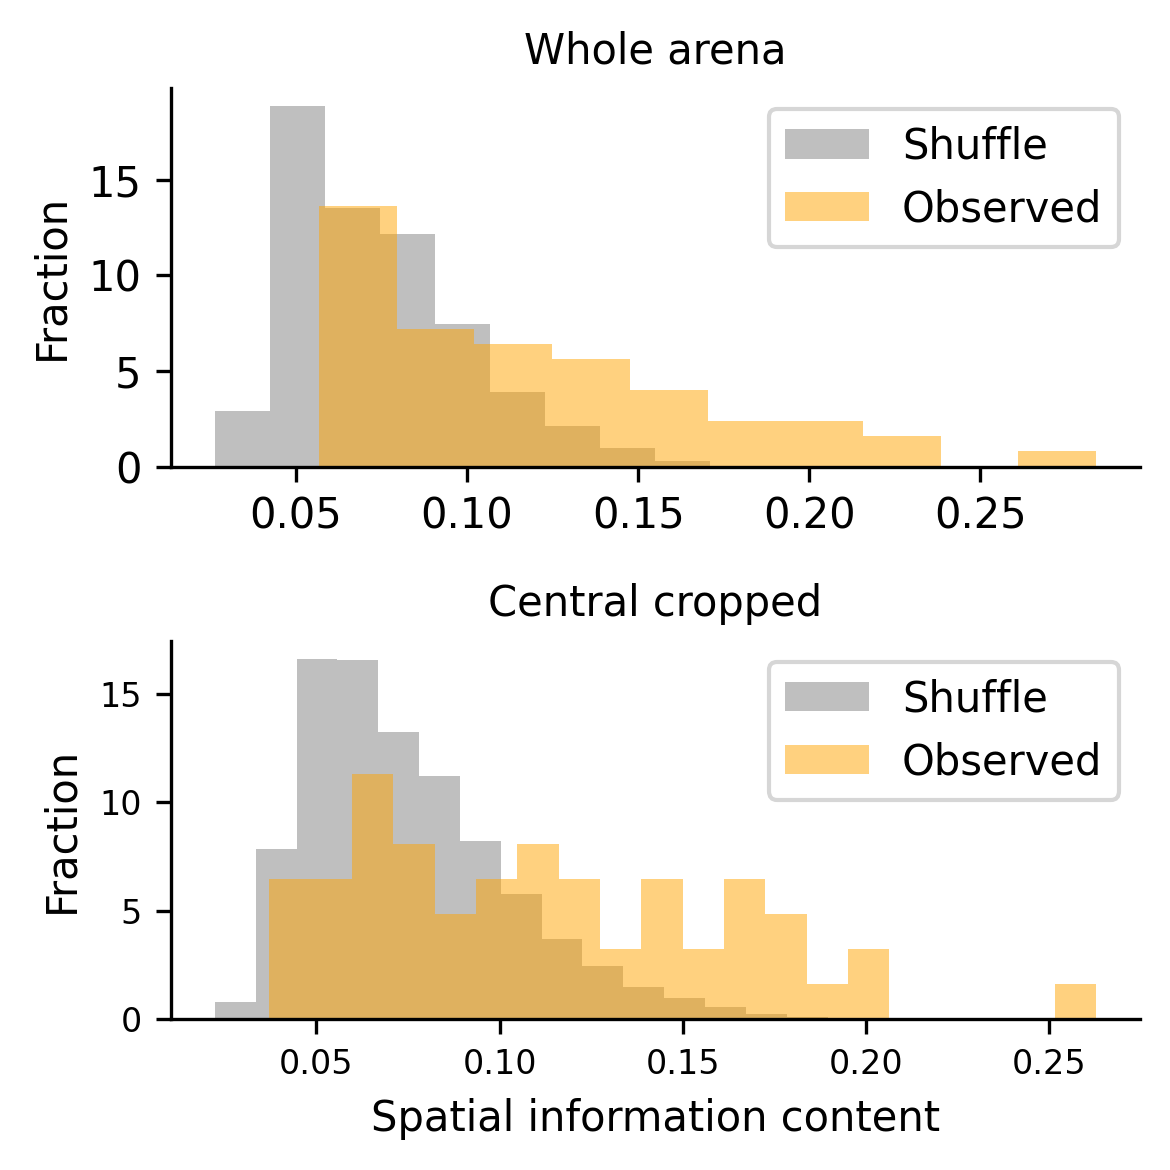

In [15]:
#plot  histogram, but with different colors
fig, axs = plt.subplots(2, 1, figsize=(4, 4), dpi=300)
labelsize = 10
ticksize = 8

axs[0].hist(np.concatenate(SIC_shuffle_all), bins=10, color='gray', alpha=0.5, label='Shuffle', density=True)
axs[0].hist(SIC_real_all, bins=10, color='orange', alpha=0.5, label='Observed', density=True) 
#histtype='step', 

axs[0].legend(fontsize=labelsize)
#axs[0].set_xlabel('Spatial information content', fontsize=labelsize)
axs[0].set_ylabel('Fraction', fontsize=labelsize)
#axs[0].set_xticks([0.3, 0.5, 0.7])
#axs[0].tick_params(labelsize=ticksize)
#axs[0].set_xticks([0.1, 0.2])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].legend()
#title
axs[0].set_title('Whole arena', fontsize=labelsize)

#plot the histogram of SIC_real_all_cut and SIC_shuffle_all_cut
axs[1].hist(np.concatenate(SIC_shuffle_all_cut), bins=20, color='gray', alpha=0.5, label='Shuffle', density=True)
axs[1].hist(SIC_real_all_cut, bins=20, color='orange', alpha=0.5, label='Observed', density=True) 

axs[1].legend(fontsize=labelsize)
axs[1].set_xlabel('Spatial information content', fontsize=labelsize)
axs[1].set_ylabel('Fraction', fontsize=labelsize)
#axs[1].set_xticks([0.1, 0.3, 0.5])
axs[1].tick_params(labelsize=ticksize)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend()
#title
axs[1].set_title('Central cropped', fontsize=labelsize)

plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'Spatial_information_content.pdf'), dpi=300, bbox_inches='tight')
    

### 10, get correlation between half-session spatial tuning maps both raw and center crop env

In [56]:
#for each neuron, calculate the tuning map
Corr_real_all = []; Corr_real_all_cut = []
Corr_shuffle_all = []; Corr_shuffle_all_cut = []
half_time = timestamps[len(timestamps)//2]

for i, key in enumerate(selected_valid_maps.keys()):
    print('Calculating spatial information content of cell '+str(key))
    
    half1_spks_cells = spks[key][timestamps<half_time]
    half1_Traj_x = Traj_x[timestamps<half_time]
    half1_Traj_z = Traj_z[timestamps<half_time]
    half1_timestamps = timestamps[timestamps<half_time]
    
    map1_real = getTuningMap(half1_spks_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None,
                        apply_adaptive_binning = False) #set peak_thres to a large number to avoid plotting
    
    #second one plot the second half data
    half2_spks_cells = spks[key][timestamps>=half_time]
    half2_Traj_x = Traj_x[timestamps>=half_time]
    half2_Traj_z = Traj_z[timestamps>=half_time]
    half2_timestamps = timestamps[timestamps>=half_time]
    map2_real = getTuningMap(half2_spks_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None,
                        apply_adaptive_binning = False) #set peak_thres to a large number to avoid plotting
    
    #set nan values as o in both maps
    map1_real[np.isnan(map1_real)] = 0
    map2_real[np.isnan(map2_real)] = 0
    
    #calculate the correlation coefficient
    corr_real =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all.append(corr_real)
    
    # cut the border for 5 pixels and keep teh remaining 30*30 pixels
    map1_real = map1_real[5:-5, 5:-5]
    map2_real = map2_real[5:-5, 5:-5]
    corr_real_cut =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all_cut.append(corr_real_cut)
    
    #shuffle spks[i] by rolling it with a random number between 0 and 1800
    #do this N times
    N=200
    corr_shuffle = np.zeros(N)
    corr_shuffle_cut = np.zeros(N)
    spks_shuffle = np.zeros((N, len(spks[key])))
    for j in range(N):
        spks_shuffle[j] = np.roll(spks[key], np.random.randint(1800, 100000))
    
    half1_spks_cells = spks_shuffle[:,timestamps<half_time] 
    #return map using getTuningMap_shuffle
    map1_shuffle_all = getTuningMap_shuffle(half1_spks_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                                binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                                return_gaussian_filtered=True, apply_adaptive_binning = False)
    
    half2_spks_cells = spks_shuffle[:,timestamps>=half_time]
    map2_shuffle_all = getTuningMap_shuffle(half2_spks_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                                binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                                return_gaussian_filtered=True, apply_adaptive_binning = False)
    
    #for each shuffled data, calculate the correlation coefficient
    for j in range(N):
        #set nan values as o in both maps
        map1_shuffle = map1_shuffle_all[j]
        map2_shuffle = map2_shuffle_all[j]
        map1_shuffle[np.isnan(map1_shuffle)] = 0
        map2_shuffle[np.isnan(map2_shuffle)] = 0
        #calculate the correlation coefficient
        corr_shuffle[j] =  np.corrcoef(map1_shuffle.flatten(), map2_shuffle.flatten())[0,1]
        
        # cut the border for 5 pixels and keep teh remaining 30*30 pixels
        map1_shuffle = map1_shuffle[5:-5, 5:-5]
        map2_shuffle = map2_shuffle[5:-5, 5:-5]
        corr_shuffle_cut[j] =  np.corrcoef(map1_shuffle.flatten(), map2_shuffle.flatten())[0,1]
            
    Corr_shuffle_all.append(corr_shuffle)
    Corr_shuffle_all_cut.append(corr_shuffle_cut)


Calculating spatial information content of cell 0
Calculating spatial information content of cell 1
Calculating spatial information content of cell 2
Calculating spatial information content of cell 3
Calculating spatial information content of cell 5
Calculating spatial information content of cell 6
Calculating spatial information content of cell 7
Calculating spatial information content of cell 8
Calculating spatial information content of cell 9
Calculating spatial information content of cell 10
Calculating spatial information content of cell 11
Calculating spatial information content of cell 12
Calculating spatial information content of cell 13
Calculating spatial information content of cell 14
Calculating spatial information content of cell 15
Calculating spatial information content of cell 16
Calculating spatial information content of cell 17
Calculating spatial information content of cell 20
Calculating spatial information content of cell 22
Calculating spatial information content 

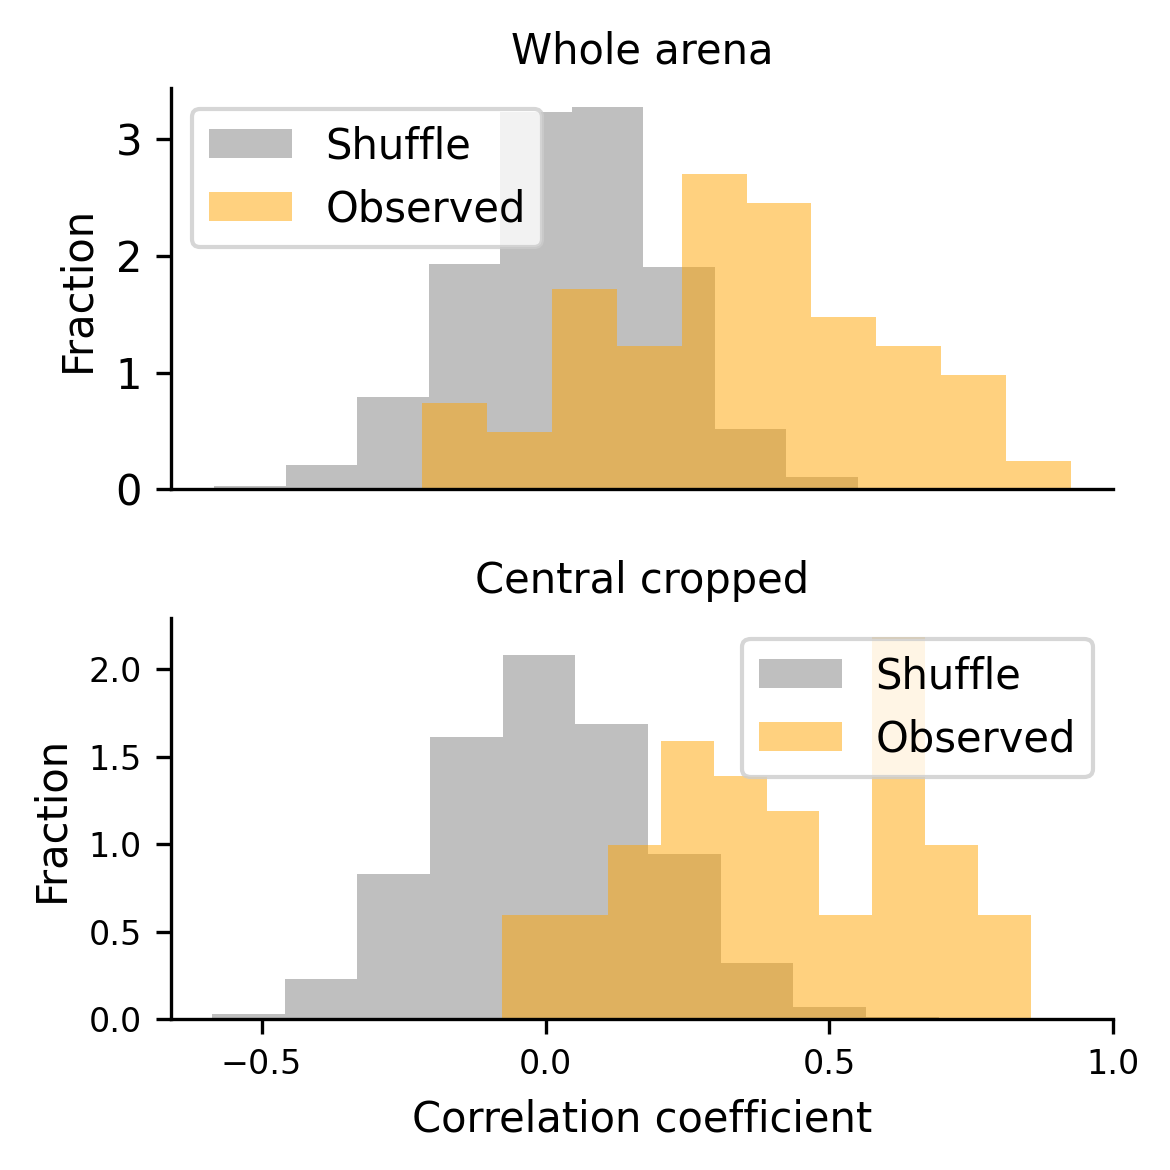

In [57]:
#plot Corr_real_all and Corr_shuffle_all in histogram, but with different colors
fig, axs = plt.subplots(2, 1, figsize=(4, 4), dpi=300)
labelsize = 10
ticksize = 8
#first plot Corr_real_all and Corr_shuffle_all in histogram, but with different colors
axs[0].hist(np.concatenate(Corr_shuffle_all), bins=10, color='gray', alpha=0.5, label='Shuffle', density=True)
axs[0].hist(Corr_real_all, bins=10, color='orange', alpha=0.5, label='Observed', density=True)

axs[0].legend(fontsize=ticksize, loc='upper right')
#axs[0].set_xlabel('Correlation coefficient', fontsize=labelsize)
axs[0].set_ylabel('Fraction', fontsize=labelsize)
#axs[0].set_xticks(np.linspace(-0.5, 1, 4))
#axs[0].tick_params(labelsize=ticksize)
axs[0].set_xticks([])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].legend()
axs[0].set_title('Whole arena', fontsize=labelsize)

#second plot Corr_real_all_cut and Corr_shuffle_all_cut in histogram, but with different colors
axs[1].hist(np.concatenate(Corr_shuffle_all_cut), bins=10, color='gray', alpha=0.5, label='Shuffle', density=True)
#histgram of Corr_real_all_cut, but without fill color, border color is orange
axs[1].hist(Corr_real_all_cut, bins=10, color='orange', alpha=0.5, label='Observed', density=True)

axs[1].legend(fontsize=ticksize, loc='upper right')
axs[1].set_xlabel('Correlation coefficient', fontsize=labelsize)
axs[1].set_ylabel('Fraction', fontsize=labelsize)
axs[1].set_xticks(np.linspace(-0.5, 1, 4))
axs[1].tick_params(labelsize=ticksize)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend()
axs[1].set_title('Central cropped', fontsize=labelsize)

plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'Correlation_half_session.pdf'), dpi=300, bbox_inches='tight')
